### STATS 202 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import statements
# import matplotlib.pyplot as plt
# from matplotlib.colors import Colormap
import random
import matplotlib
# matplotlib.use('Agg') # set the backend before importing pyplot

import matplotlib.pyplot as plt # etc. etc.

from matplotlib.colors import Colormap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
import sklearn
from bayes_opt import BayesianOptimization
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate, GridSearchCV, GroupKFold
from sklearn import linear_model, kernel_ridge
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report,log_loss
import xgboost as xgb
import patsy
import library
from mpl_toolkits.mplot3d import Axes3D

#panel data
from linearmodels import PanelOLS


warnings.filterwarnings('ignore')

# Load Data

In [3]:
#load all studies
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
    
allTrialsDF = pd.concat(trials)

#ERROR value in 'Country' variable needs to be corrected
#60014 --> USA
#60025 --> Russia
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60014)] = "USA"
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60025)] = "RUSSIA"


#Create dummy variables for Study
allTrialsDF['TxGroup'] = pd.factorize(allTrialsDF.TxGroup)[0]
#drop UK explictly instead of first
countryDummies = pd.get_dummies(allTrialsDF.Country,prefix='Country').drop(['Country_UK'],axis=1)
studyDummies = pd.get_dummies(allTrialsDF.Study,drop_first=True,prefix='Study')
# allTrialsDF = allTrialsDF.drop(['Country','Study'],axis=1)

allTrialsDF = pd.concat([allTrialsDF,countryDummies,studyDummies],axis=1)

#change lead status to binary values
factors = {'Passed': 0, 'Flagged': 1,'Assign to CS':1}
allTrialsDF['LeadStatus'].replace(factors,inplace = True)

In [4]:
# add variables for lag, diff, sums of (p,n,g)

#sort the data by patient and visits
allSortedDF = allTrialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True]).reset_index().drop(['index'],axis=1)

# Add relative visit day variable
for name,group in allSortedDF.groupby('PatientID').__iter__():
    idx = 0
    for row_index,row in group.iterrows():
        allSortedDF.at[row_index,'RelativeVisitDay'] = idx
        idx+=1

#get sum of Ps,Ns,Gs
Ps=['P1', 'P2', 'P3', 'P4', 'P5','P6', 'P7']
Gs=['G1','G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15','G16']
Ns=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
allSortedDF['Ps'] = allSortedDF[Ps].sum(axis=1)
allSortedDF['Gs'] = allSortedDF[Gs].sum(axis=1)
allSortedDF['Ns'] = allSortedDF[Ns].sum(axis=1)

#diff of PANSS_Total
allSortedDF['PANSS_Total_diff_1'] = allSortedDF.groupby('PatientID')['PANSS_Total'].diff()

#get first lags for PANSS, Ps, Gs, Ns
for col in ['Ps','Ns','Gs','PANSS_Total','PANSS_Total_diff_1']:
    newCol = col+"_lag_1"
    allSortedDF[newCol] = allSortedDF.groupby('PatientID')[col].shift(1)
    
#fill na for lags
allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1']
# let values of nan for lag of diff (occurs when visit day= 0), 
allSortedDF['PANSS_Total_diff_1_lag_1'] = allSortedDF['PANSS_Total_diff_1_lag_1']
allSortedDF['Gs_lag_1'] = allSortedDF['Gs_lag_1']
allSortedDF['Ns_lag_1'] = allSortedDF['Ns_lag_1']
allSortedDF['Ps_lag_1'] = allSortedDF['Ps_lag_1']

# Treatment Effect

In [9]:
hypotDF = allSortedDF
hypotDF['PatientID'] = pd.Categorical(hypotDF['PatientID'])
# type(hypotDF['PatientID'][20])

formula = "PANSS_Total_diff_1 ~ TxGroup + VisitDay"
olsModel = smf.ols(formula,data=allSortedDF).fit()
print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:     PANSS_Total_diff_1   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     109.9
Date:                Tue, 13 Aug 2019   Prob (F-statistic):           3.23e-48
Time:                        23:42:03   Log-Likelihood:                -77048.
No. Observations:               22909   AIC:                         1.541e+05
Df Residuals:                   22906   BIC:                         1.541e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7157      0.079    -34.484      0.0

In [12]:
formula = "PANSS_Total_diff_1 ~ TxGroup + VisitDay + PatientID"
olsModel = smf.ols(formula,data=allSortedDF).fit()
print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:     PANSS_Total_diff_1   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.7978
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               1.00
Time:                        23:46:49   Log-Likelihood:                -75882.
No. Observations:               22909   AIC:                         1.577e+05
Df Residuals:                   19961   BIC:                         1.814e+05
Df Model:                        2947                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.3548      2

In [38]:
for var in ['Ps','Gs','Ns']:
    formula = var+" ~ TxGroup:VisitDay+VisitDay "
    olsModel = smf.ols(formula,data=allSortedDF).fit()
    print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:                     Ps   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     4546.
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        00:04:54   Log-Likelihood:                -71459.
No. Observations:               22909   AIC:                         1.429e+05
Df Residuals:                   22906   BIC:                         1.429e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           19.7352      0.050  

# Patient Segmentation

In [43]:
firstVisits = allSortedDF.groupby('PatientID').first()[['PANSS_Total','Ps','Gs','Ns']+Ps+Gs+Ns]
# normalize the data and create a df out of it
firstVisitsScaled = normalize(firstVisits,axis=0)
firstVisitsScaledDF = pd.DataFrame(firstVisitsScaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(firstVisitsScaledDF, 'complete',metric='euclidean')


<IPython.core.display.Javascript object>


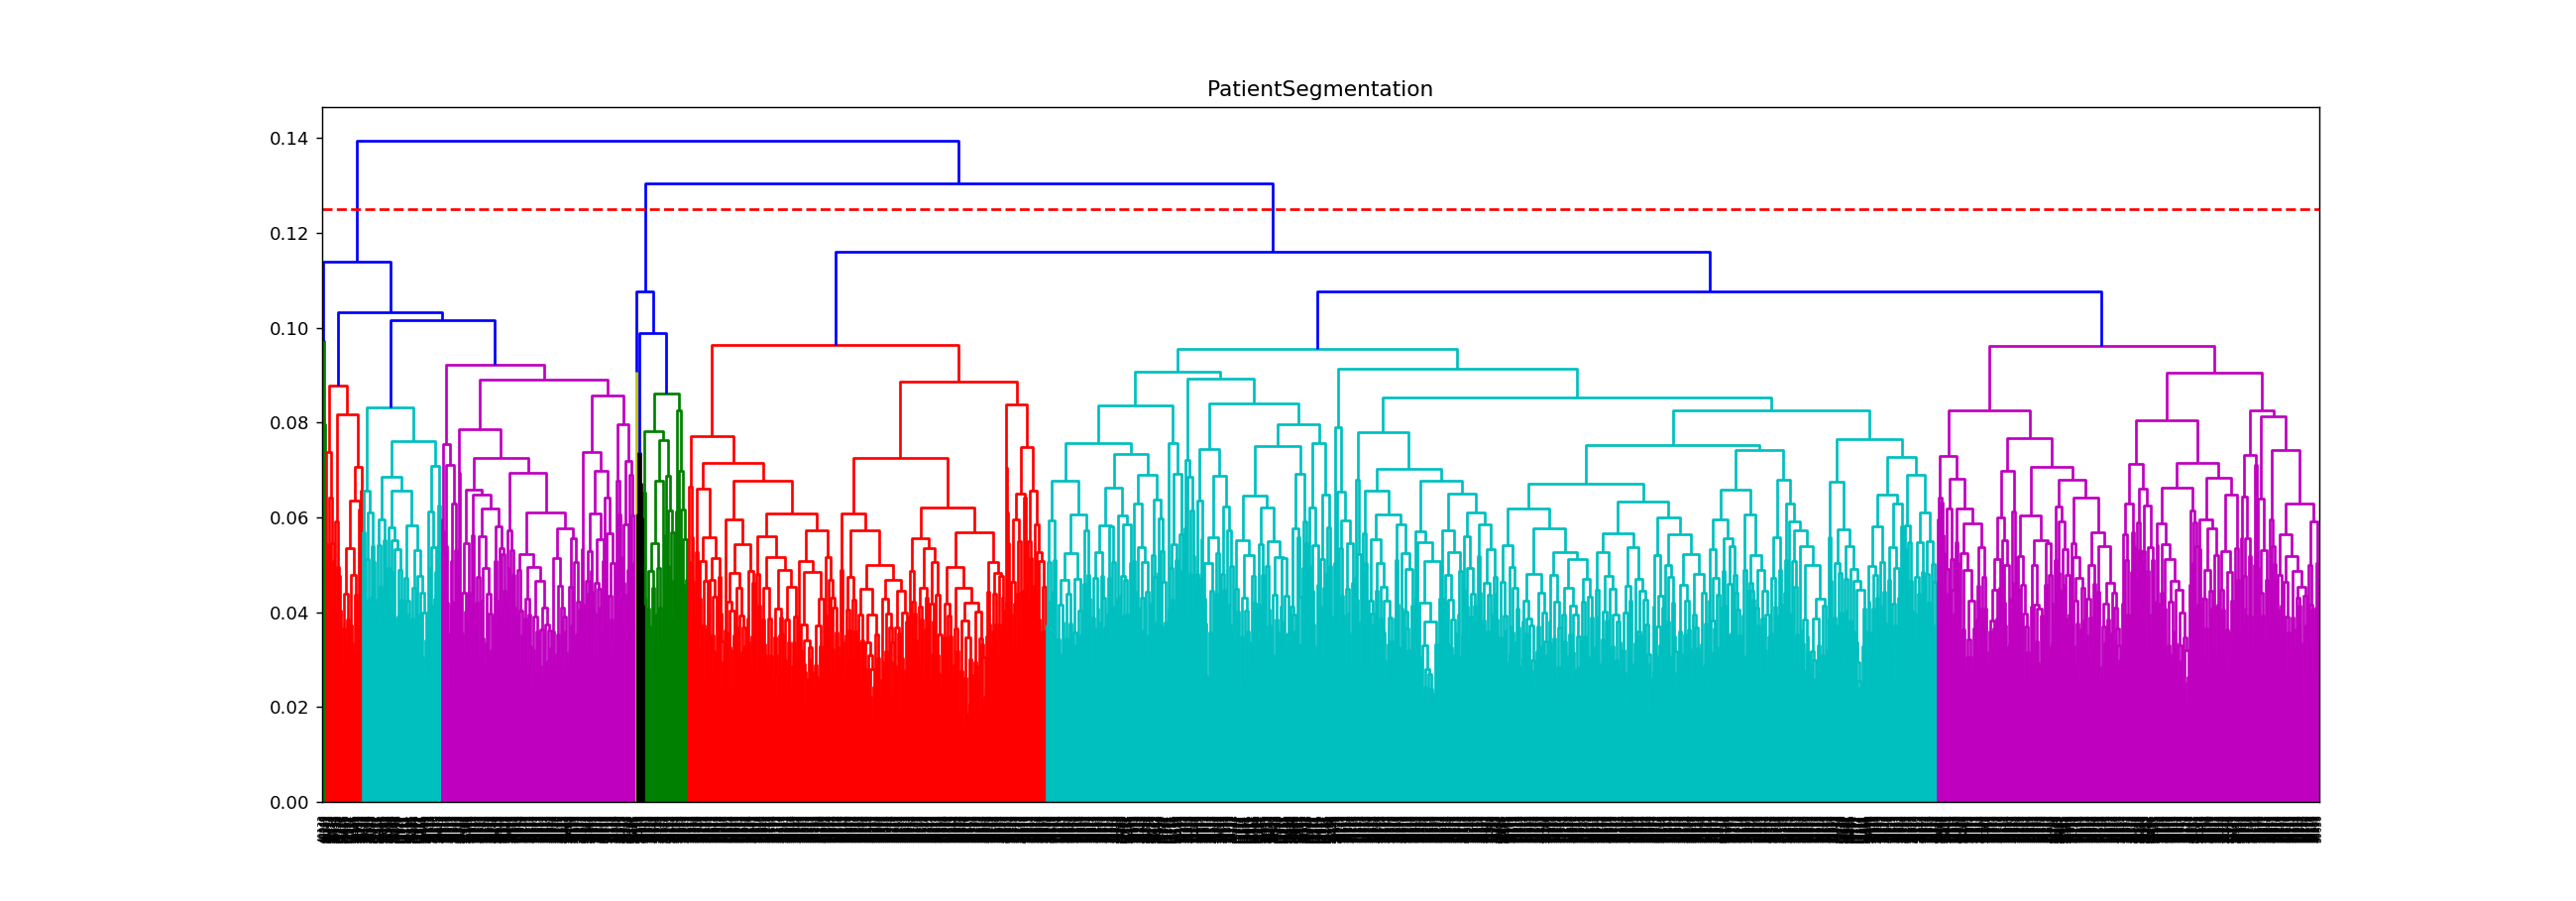

In [51]:
plt.figure(figsize=(20, 7))  
dendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.125, color='r', linestyle='--')
plt.show() 

<IPython.core.display.Javascript object>


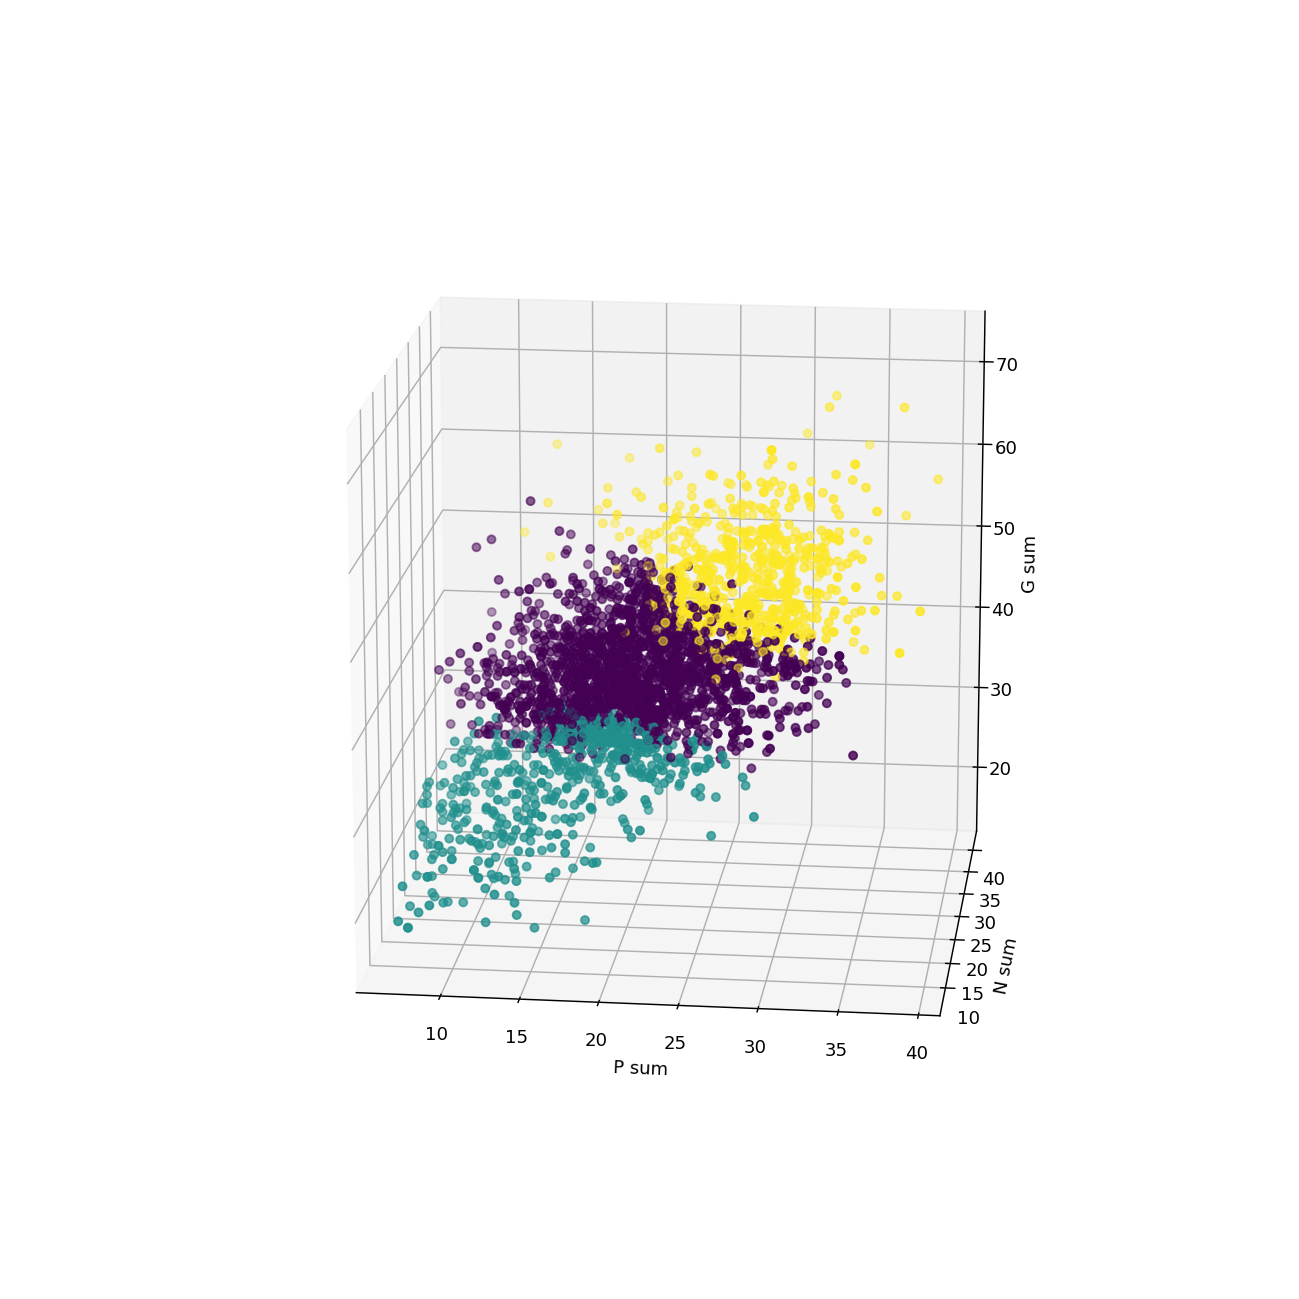

In [49]:
numClusters = 3
aggClustering = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')
aggClusteringFit = aggClustering.fit_predict(firstVisits)

%matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=aggClustering.labels_, cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()


<IPython.core.display.Javascript object>


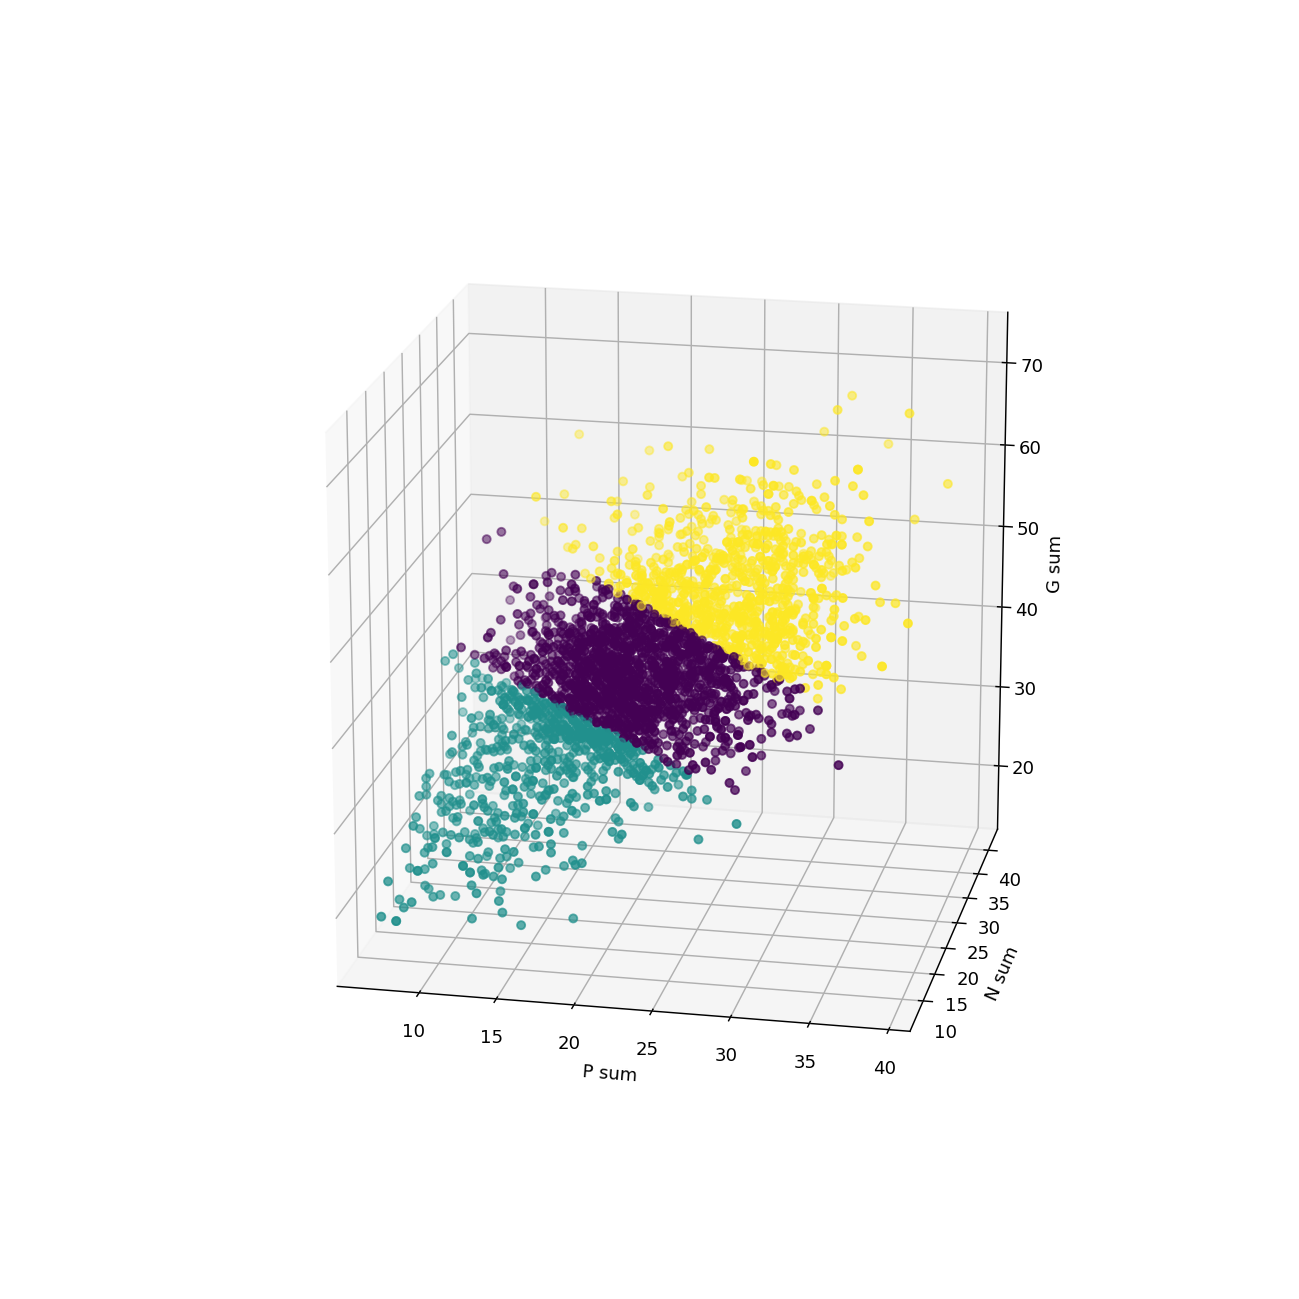

In [50]:
kMeansCenters = []
#get centers from previous clustering
for k in np.unique(aggClusteringFit):
    #for each parameter
    kthMeans = []
    for p in firstVisits.columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[aggClustering.labels_ == k]))
    kMeansCenters.append(np.asarray(kthMeans))
    
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(kMeansCenters),random_state=1).fit(firstVisits)

#plot
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()

# Forecasting

In [9]:
#divide set into training and test data

#first, get all the possible attributes that we might want
studies = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Study_")== True])
countries = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Country_")== True])
X = ['TxGroup','RelativeVisitDay','PANSS_Total_lag_1']+studies+countries
y = ['PANSS_Total']

#remove first visits as we cannot use that to make predictions (there is no previous data on it)
forecastDF = allSortedDF
forecastDF = forecastDF.loc[forecastDF.VisitDay != 0]

xSet = forecastDF[X]
ySet = forecastDF[y]

groups = forecastDF['PatientID']
patientsSplit = GroupKFold(n_splits=4)

for trainIndex, testIndex in patientsSplit.split(xSet, ySet, groups):
    xTrain, xTest = xSet.iloc[trainIndex], xSet.iloc[testIndex]
    yTrain, yTest = ySet.iloc[trainIndex], ySet.iloc[testIndex]
    trainGroups = forecastDF.iloc[trainIndex]['PatientID']
    testGroups = forecastDF.iloc[testIndex]['PatientID']
    break
    
trainDF = pd.concat([xTrain,yTrain],axis=1)

In [10]:
#get ids of the users for whom we need to make predictions/classification
submissionIDs = pd.read_csv("sample_submission_PANSS.csv").PatientID

In [69]:
#make the prediction by first making the df for the features being used
extraCols = ['PANSS_Total']
submissionXDF = allSortedDF.loc[allSortedDF.PatientID.isin(submissionIDs)][X+['PatientID']+extraCols]
submissionXDF = submissionXDF.groupby('PatientID').last()
for col in extraCols:
    submissionXDF[col+"_lag_1"] = submissionXDF[col]
submissionXDF['RelativeVisitDay'] = submissionXDF['RelativeVisitDay']+1
submissionXDF = submissionXDF.drop(extraCols,axis=1)

In [13]:
# Bagging approach - Hyperparameter tuning
def bagging_regression_cv(
    degree,
    n_features_to_select,
    max_leaf_nodes,
    n_estimators):
    
    np.random.seed(5)
    baseModel = DecisionTreeRegressor(random_state=1234,max_leaf_nodes=int(max_leaf_nodes))

    baggingModelReg = Pipeline([
      ('transformation', PolynomialFeatures(degree=int(degree))),
      ('feature_selection', RFE(baseModel,n_features_to_select=int(n_features_to_select))),
      ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=int(n_estimators)))
    ])
    
    #run CV on pipeline
    scores = cross_val_score(baggingModelReg, 
                            xTrain,
                            yTrain, 
                            cv=4,
                            scoring='neg_mean_squared_error',
                            groups=trainGroups)
    return scores.mean()
    
params={'degree':(1,3),
        'n_features_to_select':(1,32),
        'max_leaf_nodes':(2,64),
        'n_estimators':(10,3000)}

baggOptimizerReg = BayesianOptimization(f=bagging_regression_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
baggOptimizerReg.maximize(n_iter=10)


|   iter    |  target   |  degree   | max_le... | n_esti... | n_feat... |
-------------------------------------------------------------------------
|  10       | -52.48    |  1.522    |  40.46    |  1.319e+0 |  26.4     |
|  15       | -52.48    |  1.326    |  40.08    |  1.319e+0 |  26.06    |


In [15]:
print(baggOptimizerReg.res)
print("=====================================================")
print(baggOptimizerReg.max)

[{'target': -52.489271828877165, 'params': {'degree': 1.3830389007577846, 'max_leaf_nodes': 40.57074380446957, 'n_estimators': 1318.8059396312724, 'n_features_to_select': 25.346116095126845}}, {'target': -53.32758689089904, 'params': {'degree': 2.559951616237607, 'max_leaf_nodes': 18.90074152752378, 'n_estimators': 836.6281228778591, 'n_features_to_select': 25.858037503585596}}, {'target': -53.260833906920254, 'params': {'degree': 2.91627870736741, 'max_leaf_nodes': 56.30782335400987, 'n_estimators': 1079.8736371740213, 'n_features_to_select': 16.530848891227222}}, {'target': -53.16866670200083, 'params': {'degree': 2.3669258703442724, 'max_leaf_nodes': 46.18752567293981, 'n_estimators': 1117.0497568232809, 'n_features_to_select': 18.397081768034372}}, {'target': -160.68587544739552, 'params': {'degree': 2.0061663306156197, 'max_leaf_nodes': 2.853643874622299, 'n_estimators': 2320.7515986209983, 'n_features_to_select': 28.361876909719612}}, {'target': -53.217299447111365, 'params': {'d

In [70]:
#train model with tuned parameters
# {'degree': 1.3258098682446886, 
#  'max_leaf_nodes': 40.081773776102615, 
#  'n_estimators': 1318.8278885926463, 
#  'n_features_to_select': 26.062294918861273}

np.random.seed(5)
baseModel = DecisionTreeRegressor(random_state=1234,max_leaf_nodes=int(baggOptimizerReg.max['params']['max_leaf_nodes']))

baggingModelReg = Pipeline([
  ('transformation', PolynomialFeatures(degree=int(baggOptimizerReg.max['params']['degree']))),
  ('feature_selection', RFE(baseModel,n_features_to_select=int(baggOptimizerReg.max['params']['n_features_to_select']))),
  ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=int(baggOptimizerReg.max['params']['n_estimators'])))
]) 

baggModelRegFit = baggingModelReg.fit(xTrain,yTrain)

yPredTrainBagReg = baggingModelReg.predict(xTrain)
yPredTestBagReg = baggingModelReg.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrainBagReg,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTestBagReg,np.asarray(yTest.PANSS_Total))))


Train MSE:48.01295167351597
Test MSE:53.77674783311455


In [17]:
predictions = baggingModelReg.predict(submissionXDF)
submission = pd.DataFrame(columns=['PatientID','PANSS_Total'])
submission['PANSS_Total'] = predictions
submission['PatientID'] = submissionIDs
submission.to_csv("regression_submissions/forecast_submit_bagg_decision_tree_final.csv",index=False)

In [64]:
#hyperparameter tuning for xgb 
def xgb_cv(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBRegressor(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='reg:squarederror',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate).fit(xTrain,yTrain)
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_mean_squared_error',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}
optimizer = BayesianOptimization(f=xgb_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
optimizer.maximize(n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  3        | -52.43    |  0.7083   |  0.007156 |  4.222    |  7.928    |  3.012e+0 |  0.1123   |
|  4        | -51.95    |  0.7878   |  0.008838 |  4.189    |  8.308    |  1.302e+0 |  0.4283   |


In [66]:
print(optimizer.res)
print("=====================================================")
print(optimizer.max)

[{'target': -54.10865621716088, 'params': {'colsample_bytree': 0.2704523108372141, 'learning_rate': 0.006258876833294336, 'max_depth': 4.626366434042687, 'min_child_weight': 9.497510085996385, 'num_estimators': 4119.903232475214, 'subsample': 0.3426074187015511}}, {'target': -54.55887525347778, 'params': {'colsample_bytree': 0.3460531870773561, 'learning_rate': 0.008038534557596691, 'max_depth': 7.748836122102231, 'min_child_weight': 10.131528443194663, 'num_estimators': 2431.2690798314666, 'subsample': 0.5458856617158783}}, {'target': -52.43438231435749, 'params': {'colsample_bytree': 0.7082820123032013, 'learning_rate': 0.007155750067130713, 'max_depth': 4.221504528742369, 'min_child_weight': 7.9283733024593745, 'num_estimators': 3012.332661231239, 'subsample': 0.1122539201357072}}, {'target': -51.945241809980544, 'params': {'colsample_bytree': 0.7878156932350129, 'learning_rate': 0.008838147787297555, 'max_depth': 4.189315903408234, 'min_child_weight': 8.307773249034456, 'num_estima

In [67]:
# {'colsample_bytree': 0.7878156932350129, 
#  'learning_rate': 0.008838147787297555, 
#  'max_depth': 4.189315903408234,
#  'min_child_weight': 8.307773249034456, 
#  'num_estimators': 1301.5249665719061, 
#  'subsample': 0.4282533653417573}

#train xgb model
max_depth = int(4.189315903408234)
min_child_weight = 8.307773249034456
subsample = 0.4282533653417573
colsample_bytree = 0.7878156932350129 
objective = 'reg:squarederror'
num_estimators = int(1301)
learning_rate = 0.008838147787297555

boostModel = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict(xTrain)
yPredTest = boostModelFit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))

Train MSE:45.9569377928259
Test MSE:51.77004507922223


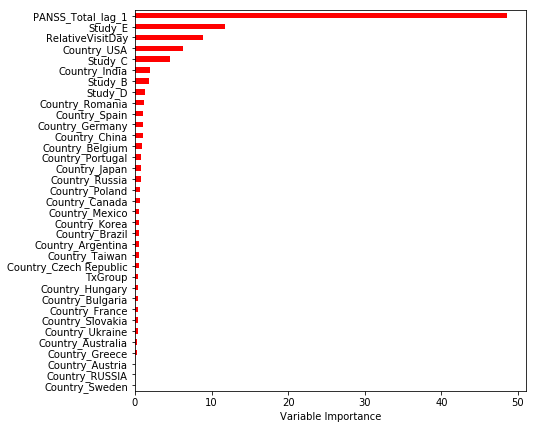

In [73]:
Importance = pd.DataFrame({'Importance':boostModelFit.feature_importances_*100}, index=xTrain.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(7,7) )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [74]:
predictions = boostModel.predict(submissionXDF)
submission = pd.DataFrame(columns=['PatientID','PANSS_Total'])
submission['PANSS_Total'] = predictions
submission['PatientID'] = submissionIDs
submission.to_csv("regression_submissions/forecast_submit_XGB_final.csv",index=False)

# Classification

In [75]:
def checkMultipleValuesShared(df,group,column):
    print(group+":"+str(sum(df.groupby([group])[column].unique().apply(lambda x:1 if len(x) > 1 else 0))>0))

# check if possible to have multiple studies with same values. 
checkMultipleValuesShared(allSortedDF,'Country','Study')
checkMultipleValuesShared(allSortedDF,'SiteID','Study')
checkMultipleValuesShared(allSortedDF,'PatientID','Study')
checkMultipleValuesShared(allSortedDF,'RaterID','Study')


Country:True
SiteID:False
PatientID:False
RaterID:False


In [76]:
#divide set into training and test data

#first, get all the possible attributes that we might want

# since each patient,site,Rater is unique to the study, cannot use those as features

countries = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Country_")== True])
X = ['TxGroup','VisitDay','RelativeVisitDay','PANSS_Total_lag_1','PANSS_Total',
     'PANSS_Total_diff_1_lag_1','Ns_lag_1','Gs_lag_1','Ns','Gs']
# X = ['VisitDay','RelativeVisitDay']
y = ['LeadStatus']

#fill na for lags
allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1'].fillna(allSortedDF.PANSS_Total)
# let values of nan for lag of diff (occurs when visit day= 0), equal 0
allSortedDF['PANSS_Total_diff_1_lag_1'] = allSortedDF['PANSS_Total_diff_1_lag_1'].fillna(0)
allSortedDF['Gs_lag_1'] = allSortedDF['Gs_lag_1'].fillna(allSortedDF.Gs)
allSortedDF['Ns_lag_1'] = allSortedDF['Ns_lag_1'].fillna(allSortedDF.Ns)

groupVar = 'PatientID'

classificationDF = allSortedDF.loc[allSortedDF['Study_E'] == 0][X+y+[groupVar]]
resultDF = allSortedDF.loc[allSortedDF['Study_E'] == 1][X+['AssessmentiD']+[groupVar]]

xSet = classificationDF[X]
ySet = classificationDF[y]

from sklearn.model_selection import GroupKFold

# need to do groupfold CV as we are creating probs for patients never seen before
groups = classificationDF[groupVar]
patientsSplit = GroupKFold(n_splits=4)

for trainIndex, testIndex in patientsSplit.split(xSet, ySet, groups):
    xTrain, xTest = xSet.iloc[trainIndex], xSet.iloc[testIndex]
    yTrain, yTest = ySet.iloc[trainIndex], ySet.iloc[testIndex]
    trainGroups = classificationDF.iloc[trainIndex][groupVar]
    testGroups = classificationDF.iloc[testIndex][groupVar]
    break

Text(0, 0.5, 'VisitDay')

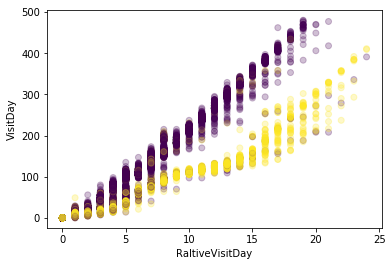

In [92]:
#purple = pass,yellow = flagged/assigned
plt.scatter(xTrain.RelativeVisitDay,xTrain.VisitDay,c=list(yTrain.LeadStatus),alpha=0.25)
plt.xlabel("RaltiveVisitDay")
plt.ylabel("VisitDay")

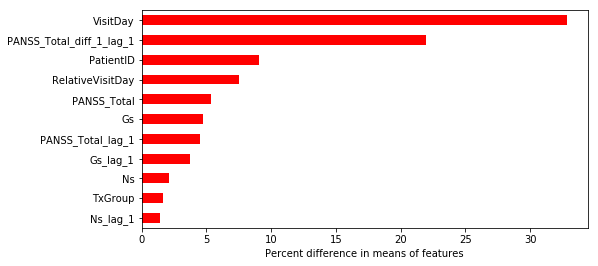

In [79]:
# visualize the difference in means of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
means = classificationDF.groupby(['LeadStatus']).mean().transpose()
means['diff'] = 100*(means[0.0]-means[1.0])/means[0.0]

Importance = pd.DataFrame({'Importance':np.abs(means['diff'])}, index=means.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,4)) 
plt.xlabel('Percent difference in means of features')

plt.gca().legend_ = None


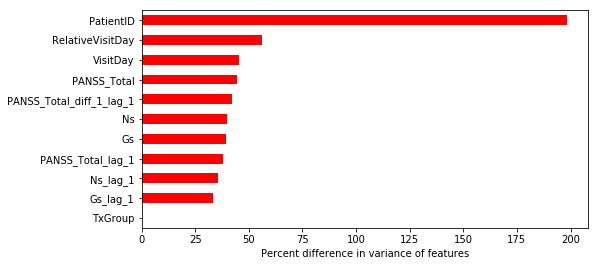

In [80]:
# visualize the difference in vars of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
variances = classificationDF.groupby(['LeadStatus']).var().transpose()
variances['diff'] = 100*(variances[0.0]-variances[1.0])/variances[0.0]

Importance = pd.DataFrame({'Importance':np.abs(variances['diff'])}, index=variances.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,4)) 
plt.xlabel('Percent difference in variance of features')

plt.gca().legend_ = None

In [81]:
# try gradient boosting
def xgb_cv_classifier(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBClassifier(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='binary:logistic',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate,
                random_state=123).fit(xTrain,yTrain)
    
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}

optimizer = BayesianOptimization(f=xgb_cv_classifier,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
optimizer.maximize(n_iter=10)


|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  2        | -0.4543   |  0.3461   |  0.008039 |  7.749    |  10.13    |  2.431e+0 |  0.5459   |
|  7        | -0.4526   |  0.6599   |  0.004477 |  3.58     |  10.61    |  1e+03    |  0.3672   |
|  10       | -0.4508   |  0.644    |  0.009107 |  2.238    |  4.14     |  2.668e+0 |  0.4277   |


In [82]:
print(optimizer.max)

{'target': -0.45077968810885083, 'params': {'colsample_bytree': 0.6439581323639423, 'learning_rate': 0.00910661504454726, 'max_depth': 2.237885375643249, 'min_child_weight': 4.139836467498774, 'num_estimators': 2668.4240720307685, 'subsample': 0.42773328306857494}}


In [83]:
# {'colsample_bytree': 0.6439581323639423,
#  'learning_rate': 0.00910661504454726, 
#  'max_depth': 2.237885375643249, 
#  'min_child_weight': 4.139836467498774,
#  'num_estimators': 2668.4240720307685,
#  'subsample': 0.42773328306857494}

max_depth = int(optimizer.max['params']['max_depth'])
min_child_weight = optimizer.max['params']['min_child_weight']
subsample = optimizer.max['params']['subsample']
colsample_bytree = optimizer.max['params']['colsample_bytree']
objective = 'binary:logistic'
num_estimators = int(optimizer.max['params']['num_estimators'])
learning_rate = optimizer.max['params']['learning_rate'] 

boostModel = xgb.XGBClassifier(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate,
                random_state=1234)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict_proba(xTrain)[:,1]
yPredTest = boostModelFit.predict_proba(xTest)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrain)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTest)))

Train Log loss:0.3853222970103218
Test Log loss:0.3946926731673877


In [90]:

binaryClassification = boostModelFit.predict_proba(resultDF.drop(['AssessmentiD','PatientID'],axis=1))[:,1]
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_XGB_final.csv",index=False)

In [91]:
def bagging_cv_classifier_Logit(
    n_estimators,
    max_features,
    degree,C):

    dataSet = PolynomialFeatures(degree=int(degree)).fit_transform(xTrain)
    baseEstimator = linear_model.LogisticRegression(C=C)
    baggingClassifier = BaggingClassifier(baseEstimator,
                                          n_estimators=int(n_estimators),
                                          max_features=max_features,
                                          random_state=1234).fit(dataSet,yTrain)
    
    cval = cross_val_score(baggingClassifier,xTrain,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    return cval.mean()

params={'max_features':(0.1,1.0),
        'n_estimators':(1,50),
        'degree':(1,3.1),
        'C':(0.001,1)}

baggOptimizerLogit = BayesianOptimization(f=bagging_cv_classifier_Logit,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
baggOptimizerLogit.maximize(n_iter=10)

|   iter    |  target   |     C     |  degree   | max_fe... | n_esti... |
-------------------------------------------------------------------------
|  5        | -0.4712   |  0.5036   |  1.029    |  0.7955   |  44.25    |
|  6        | -0.468    |  0.001    |  1.0      |  1.0      |  1.0      |
|  8        | -0.4667   |  0.001    |  1.0      |  1.0      |  12.89    |
|  9        | -0.4667   |  0.001    |  3.1      |  1.0      |  5.803    |


In [93]:
print(baggOptimizerLogit.max)

{'target': -0.4666672608050524, 'params': {'C': 0.001, 'degree': 3.1, 'max_features': 1.0, 'n_estimators': 5.80309757043325}}


In [94]:
# {'C': 0.001, 
#  'degree': 3.1, 
#  'max_features': 1.0, 
#  'n_estimators': 5.80309757043325}

degree = int(baggOptimizerLogit.max['params']['degree'])
trainDataBag=PolynomialFeatures(degree).fit_transform(xTrain)
testDataBag=PolynomialFeatures(degree).fit_transform(xTest)

C = baggOptimizerLogit.max['params']['C']
baggingClassifierLogit = BaggingClassifier(base_estimator=linear_model.LogisticRegression(C=C),
                                      n_estimators=int(baggOptimizerLogit.max['params']['n_estimators']),
                                      max_features=baggOptimizerLogit.max['params']['max_features'],
                                      random_state=1234)
baggingClassifierLogitFit = baggingClassifierLogit.fit(trainDataBag,yTrain)

yPredTrainBagLogit = baggingClassifierLogit.predict_proba(trainDataBag)[:,1]
yPredTestBagLogit = baggingClassifierLogit.predict_proba(testDataBag)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrainBagLogit)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTestBagLogit)))

Train Log loss:0.40261583726983524
Test Log loss:0.4091247541365901


In [96]:
resultDataBag = PolynomialFeatures(degree).fit_transform(resultDF.drop(['AssessmentiD',groupVar],axis=1))
binaryClassification = baggingClassifierLogitFit.predict_proba(resultDataBag)[:,1]
    
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_bag_logit_final.csv",index=False)

Text(0, 0.5, 'Log loss')

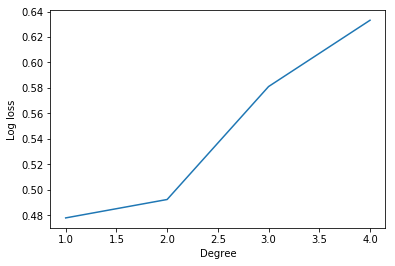

In [103]:
scores=[]
for degree in [1,2,3,4]:
    xVars = PolynomialFeatures(degree).fit_transform(xTrain[['VisitDay','RelativeVisitDay']])
    cval = cross_val_score(linear_model.LogisticRegression(),xVars,yTrain,scoring='neg_log_loss',cv=4,groups=trainGroups)
    scores.append( cval.mean())
plt.plot([1,2,3,4],np.abs(scores))
plt.xlabel("Degree")
plt.ylabel("Log loss")

In [102]:
logitModel = linear_model.LogisticRegression()
logitModel = logitModel.fit(xTrain[['VisitDay','RelativeVisitDay']],yTrain)

yPredTrainLogit = logitModel.predict_proba(xTrain[['VisitDay','RelativeVisitDay']])[:,1]
yPredTestLogit = logitModel.predict_proba(xTest[['VisitDay','RelativeVisitDay']])[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrainLogit)))
print("Test Log loss:" +str(log_loss(yTest.LeadStatus,yPredTestLogit)))

Train Log loss:0.4265113766112506
Test Log loss:0.4306522428894112


## References
1. https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
2. https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
3. https://github.com/fmfn/BayesianOptimization